In [3]:
# %pip install torch torchvision matplotlib
# CHECK CLASS NAMES BEFORE RUNNING NEW MODELS

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from IPython.display import Image as Ipimage, display
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import easyocr
import numpy as np
import difflib

c:\Users\civip\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
num_classes = 8  # DANGER
model = models.resnet50()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(model.fc.in_features, num_classes)
) 
model.load_state_dict(torch.load("resnet50_model5.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode
class_names = ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']

model_dense = models.densenet121()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model_dense.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),  # Apply dropout for regularization
    torch.nn.Linear(model_dense.classifier.in_features, num_classes)
)
model_dense.load_state_dict(torch.load("densenet121_model1.pth", map_location=device))
model_dense.to(device)
model_dense.eval()  # Set model to evaluation mode
class_names = ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']

num_classes_old = 6  # DANGER
model_old = models.resnet50()
model_old.fc = torch.nn.Linear(model_old.fc.in_features, num_classes_old)
model_old.load_state_dict(torch.load("resnet50_model_old.pth", map_location=device))
model_old.to(device)
model_old.eval()  # Set model to evaluation mode
class_names_old = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

num_classes_battery_soda = 2  # DANGER
model_battery_soda = models.resnet50()
model_battery_soda.fc = torch.nn.Linear(model_battery_soda.fc.in_features, num_classes_battery_soda)
model_battery_soda.load_state_dict(torch.load("resnet50_battery_soda.pth", map_location=device))
model_battery_soda.to(device)
model_battery_soda.eval()  # Set model to evaluation mode
class_names_battery_soda = ['battery', 'soda']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



num_classes_vit = 9  # DANGER
model_vit = models.vit_b_16()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model_vit.heads.head = torch.nn.Linear(model_vit.heads.head.in_features, num_classes_vit)

model_vit.load_state_dict(torch.load("vit_model.pth", map_location=device))
model_vit.to(device)
model_vit.eval()  # Set model to evaluation mode
class_names_vit = ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']




In [4]:
def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names[class_idx]

    print(f"Resnet Predicted Class: {class_name}", end=' | ')

def classify_image_old(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_old(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_old[class_idx]

    print(f"Old Predicted Class: {class_name}", end=' | ')

def classify_dense(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_old(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_old[class_idx]

    print(f"Dense Predicted Class: {class_name}", end=' | ')

def classify_battery_soda(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_battery_soda(image)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_battery_soda[class_idx]

    # print(f"probabilities: {probabilities}")
    # print(f"Dense Predicted Class: {class_name}", end=' | ')
    return probabilities, class_name

def classify_image_vit(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    model_vit.to(device)
    model_vit.eval()

    # Predict
    with torch.no_grad():
        outputs = model_vit(image)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_vit[class_idx]

    probs = probs.squeeze(0)
    scores = {}
    for i in range(len(class_names_vit)):
        scores[class_names_vit[i]] = round(probs[i].item(), 4)
    return scores, class_name

def ocr_score(image_path):
    look_up = {
        'battery': ['battery'],
        'AA' : ['battery'],
        'AAA' : ['battery'],
        'mah' : ['battery'],
        'duracell': ['battery'],
        'energizer': ['battery'],
        'dr pepper' : ['metal', 'glass'],
        'sprite' : ['metal', 'glass'],
        'pepsi' : ['metal', 'glass'],
        'coca cola' : ['metal', 'glass'],
        'fanta' : ['metal', 'glass'],
        'coke' : ['metal', 'glass'],
        'campbell' : ['metal'],
        'soup' : ['metal', 'plastic', 'glass'],
        'ml' : ['metal', 'plastic', 'glass'],
        'soda' : ['metal', 'plastic', 'glass']
    }
    reader = easyocr.Reader(['en'], gpu=True)
    original_img = Image.open(image_path)
    rotations = [original_img] + [original_img.rotate(angle, expand=True) for angle in [90, 180, 270]]
    output = set()
    for i, img in enumerate(rotations):
        print(f"\n--- OCR for rotation {i * 90}° ---")
        out = []
        img_np = np.array(img)
        results = reader.readtext(img_np)
        for detection in results:
            out.append(detection[1])
        
        for word in out:
            for key, val in look_up.items():
                ratio = difflib.SequenceMatcher(None, word, key).ratio()
                if ratio > 0.7:
                    print(f'scanned word: {word} | look up word: {key} | likely classes: {val} | confidence score: {ratio}')
                    for v in val:
                        output.add(v)
    return list(output)

def display_image(image_path):
    img = Image.open(image_path)
    max_width = 300
    max_height = 200
    img.thumbnail((max_width, max_height))
    display(img)

In [ ]:
image_path = f"./custom-test-images/Duracell_AA__49529.jpg"
display_image(image_path)
scores, class_name = classify_image_vit(image_path)
print(scores)
print(class_name)
ocr_score(image_path)

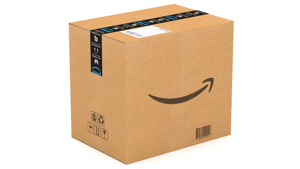

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



--- OCR for rotation 0° ---

--- OCR for rotation 90° ---

--- OCR for rotation 180° ---


KeyboardInterrupt: 

In [5]:
for test_image_path in os.listdir('custom-test-images'):
    image_path = f"./custom-test-images/{test_image_path}"
    display_image(image_path)
    scores, class_name = classify_image_vit(image_path)
    ocr_score(image_path)
    print(scores)
    print(class_name)
    # print('expected: cardboard\n')
    
    # classify_image(image_path)
    # classify_image_old(image_path)
    # classify_dense(image_path)
    print('\n-----------------------------------------------------------\n\n')


In [5]:
image_path = "./custom-test-images/amazon-cardboard-box-03.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: cardboard')


Predicted Class: cardboard | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: cardboard


In [43]:
image_path = "./custom-test-images/coke-real.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [7]:
image_path = "./custom-test-images/dietcoke.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: metal | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: metal


In [8]:
image_path = "./custom-test-images/dietcoke-removebg-preview.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [9]:
image_path = "./custom-test-images/mugs.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')


Predicted Class: battery | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [10]:
image_path = "./custom-test-images/Duracell_AA__49529.jpg"
classify_image(image_path)
classify_dense(image_path)
print('expected: battery')

Predicted Class: battery | Dense Predicted Class: metal | expected: battery


In [11]:
image_path = "./custom-test-images/wine-glass.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [12]:
image_path = "./custom-test-images/glass-container.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: metal | Old Predicted Class: metal | Dense Predicted Class: metal | expected: glass


In [13]:
image_path = "./custom-test-images/sprite.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [14]:
image_path = "./custom-test-images/fanta.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')

Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [15]:
image_path = "./custom-test-images/pie.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')

Predicted Class: metal | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [16]:
image_path = "./custom-test-images/root-beer.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [17]:
image_path = "./custom-test-images/syringe.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: syringe')

Predicted Class: syringe | Old Predicted Class: glass | Dense Predicted Class: glass | expected: syringe


In [18]:
image_path = "./custom-test-images/syringe_with_bg.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: syringe')

Predicted Class: syringe | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: syringe


In [19]:
image_path = "./custom-test-images/water-glass-removebg-preview.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: plastic | Old Predicted Class: metal | Dense Predicted Class: metal | expected: glass


In [20]:
image_path = "./custom-test-images/plastic-cup.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: plastic')

Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: plastic


In [34]:
image_path = "./custom-test-images/Duracell_AA__49529.jpg"
classify_battery_soda(image_path)
print('expected: battery')

Dense Predicted Class: battery | expected: battery


In [37]:
image_path = "./custom-test-images/dietcoke-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)


In [49]:
image_path = "./custom-test-images/fanta.webp"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/fanta2-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: battery | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)


In [40]:
image_path = "./custom-test-images/gingerale2.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)


In [45]:
image_path = "./custom-test-images/fanta2.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/fanta3.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/coke-real-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/coke2.webp"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)


In [51]:
image_path = "./custom-test-images/bluebattery.jpg"
classify_battery_soda(image_path)
print('expected: battery')

image_path = "./custom-test-images/sunkist.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/sunkist-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

probabilities: tensor([[0.9511, 0.0489]])
Dense Predicted Class: battery | expected: battery
probabilities: tensor([[0.0826, 0.9174]])
Dense Predicted Class: soda | expected: soda(metal)
probabilities: tensor([[0.0543, 0.9457]])
Dense Predicted Class: soda | expected: soda(metal)


In [64]:
# image_path = "./custom-test-images/pie.jpg"
# classify_battery_soda(image_path)

image_path = "./custom-test-images/metalcan.jpg"
scores, classification = classify_battery_soda(image_path)
battery_score, soda_score = scores.squeeze().tolist()
print(f'battery score: {battery_score} | soda score: {soda_score} | classification: {classification}')
# note: must be 80% sure it's soda to be classifed as metal 

probabilities: tensor([[0.5628, 0.4372]])
Dense Predicted Class: battery | battery score: 0.562760591506958 | soda score: 0.4372394382953644 | classification: battery
